In [1]:
# Importing Libraries
from tensorflow import keras
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras import optimizers, losses
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing import image

import pickle
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Base Path for all files
# data_dir = '../input/insect-village-synthetic-dataset/Insect Classes/Insect Classes'
data_dir = '/Users/chenxin/Desktop/Tianluo/dataset/archive'

In [3]:
# Using ImageDataGenerator to load the Images for Training and Testing the CNN Model
datagenerator = {
    "train": ImageDataGenerator(horizontal_flip=True,
                                vertical_flip=True,
                                rescale=1. / 255,
                                validation_split=0.1,
                                shear_range=0.1,
                                zoom_range=0.1,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                rotation_range=30,
                               ).flow_from_directory(directory=data_dir,
                                                     target_size=(300, 300),
                                                     subset='training',
                                                    ),

    "valid": ImageDataGenerator(rescale=1 / 255,
                                validation_split=0.1,
                               ).flow_from_directory(directory=data_dir,
                                                     target_size=(300, 300),
                                                     subset='validation',
                                                    ),
}

Found 4006 images belonging to 5 classes.
Found 443 images belonging to 5 classes.


In [4]:
# Initializing InceptionV3 (pretrained) model with input image shape as (300, 300, 3)
base_model = InceptionV3(weights=None, include_top=False, input_shape=(300, 300, 3))

# Load Weights for the InceptionV3 Model
# base_model.load_weights('../input/inceptionv3/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5')
#?
base_model = InceptionV3(weights='imagenet', include_top=True)

'''
from tensorflow.keras.applications import InceptionV3

# 加载带有预训练权重的 InceptionV3 模型
model = InceptionV3(weights='imagenet', include_top=True)

# 可选地，你可以指定一个特定的权重文件路径
# model.load_weights('path_to_weights_file.h5') 
'''


# Setting the Training of all layers of InceptionV3 model to false
base_model.trainable = False

In [5]:
# Adding some more layers at the end of the Model as per our requirement
'''
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.15),
    Dense(1024, activation='relu'),
    Dense(10, activation='softmax') # 10 Output Neurons for 10 Classes
])
'''
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, Flatten

model = Sequential([
    base_model,  # Assuming base_model is your pre-trained InceptionV3 model
    Flatten(),   # Flatten the 2D feature map to a 1D vector
    Dropout(0.15),
    Dense(1024, activation='relu'),
    Dense(5, activation='softmax') # 10 Output Neurons for 10 Classes
])


In [6]:
# Using the Adam Optimizer to set the learning rate of our final model
opt = optimizers.Adam(learning_rate=0.0001)

# Compiling and setting the parameters we want our model to use
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=['accuracy'])

In [7]:
# Viewing the summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 1000)              23851784  
                                                                 
 flatten (Flatten)           (None, 1000)              0         
                                                                 
 dropout (Dropout)           (None, 1000)              0         
                                                                 
 dense (Dense)               (None, 1024)              1025024   
                                                                 
 dense_1 (Dense)             (None, 5)                 5125      
                                                                 
Total params: 24,881,933
Trainable params: 1,030,149
Non-trainable params: 23,851,784
_________________________________________________________________


In [21]:
from keras.utils.vis_utils import plot_model
#?
# %matplotlib inline
# plot_model(model, show_shapes=True, show_layer_names=True)
from tensorflow.keras.utils import plot_model	# whatever



plot_model(model, show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [9]:
# Setting variables for the model
batch_size = 32
epochs = 10

# Seperating Training and Testing Data
train_generator = datagenerator["train"]
valid_generator = datagenerator["valid"]

In [10]:
# Calculating variables for the model
steps_per_epoch = train_generator.n // batch_size
validation_steps = valid_generator.n // batch_size

print("steps_per_epoch :", steps_per_epoch)
print("validation_steps :", validation_steps)

steps_per_epoch : 125
validation_steps : 13


In [11]:
# File Path to store the trained models
filepath = "/Users/chenxin/Desktop/Tianluo/dataset/archive/model_{epoch:02d}-{val_accuracy:.2f}.h5"

# Using the ModelCheckpoint function to train and store all the best models
checkpoint1 = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

callbacks_list = [checkpoint1]
# Training the Model
history = model.fit_generator(generator=train_generator, epochs=epochs, steps_per_epoch=steps_per_epoch,
                              validation_data=valid_generator, validation_steps=validation_steps,
                              callbacks=callbacks_list)

Epoch 1/10


2024-03-10 09:37:57.397425: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


125/125 [==============================] - ETA: 0s - loss: 1.5371 - accuracy: 0.6220
Epoch 1: val_accuracy improved from -inf to 0.81010, saving model to /Users/chenxin/Desktop/Tianluo/dataset/archive/model_01-0.81.h5
125/125 [==============================] - 222s 2s/step - loss: 1.5371 - accuracy: 0.6220 - val_loss: 1.4047 - val_accuracy: 0.8101
Epoch 2/10
125/125 [==============================] - ETA: 0s - loss: 1.3722 - accuracy: 0.7250
Epoch 2: val_accuracy improved from 0.81010 to 0.87500, saving model to /Users/chenxin/Desktop/Tianluo/dataset/archive/model_02-0.88.h5
125/125 [==============================] - 235s 2s/step - loss: 1.3722 - accuracy: 0.7250 - val_loss: 1.1549 - val_accuracy: 0.8750
Epoch 3/10
125/125 [==============================] - ETA: 0s - loss: 1.1858 - accuracy: 0.7287
Epoch 3: val_accuracy improved from 0.87500 to 0.89183, saving model to /Users/chenxin/Desktop/Tianluo/dataset/archive/model_03-0.89.h5
125/125 [==============================] - 240s 2s/ste

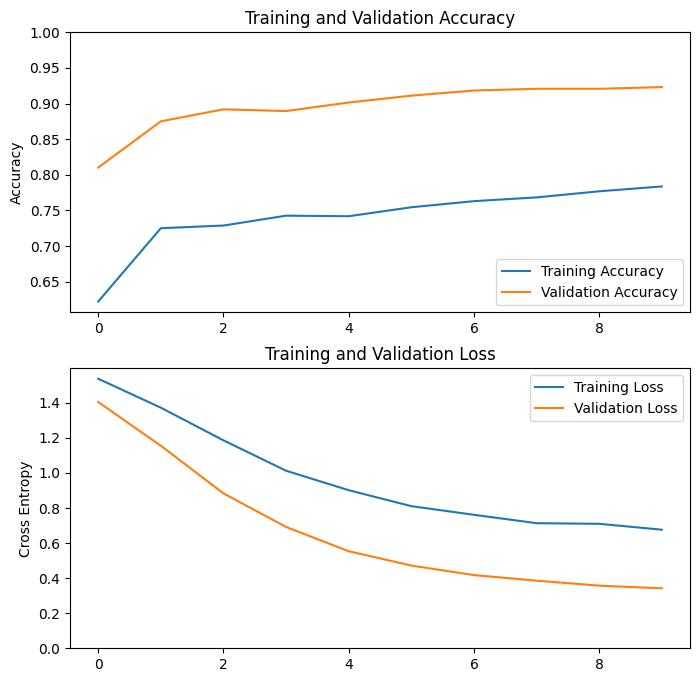

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# ________________ Graph 1 -------------------------

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

# ________________ Graph 2 -------------------------

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

In [13]:
# Calculate the Loss and Accuracy on the Validation Data
test_loss, test_acc = model.evaluate(valid_generator)
print('test accuracy : ', test_acc)

14/14 [==============================] - 22s 2s/step - loss: 0.3460 - accuracy: 0.9210
test accuracy :  0.9209932088851929


In [17]:
# Check our folder and import the model with best validation accuracy
loaded_best_model = keras.models.load_model("/Users/chenxin/Desktop/Tianluo/dataset/archive/model_06-0.91.h5")

# Custom function to load and predict label for the image
def predict(img_rel_path):
    # Import Image from the path with size of (300, 300)
    img = image.load_img(img_rel_path, target_size=(300, 300))

    # Convert Image to a numpy array
    img = image.img_to_array(img, dtype=np.uint8)

    # Scaling the Image Array values between 0 and 1
    img = np.array(img)/255.0

    # Plotting the Loaded Image
    plt.title("Loaded Image")
    plt.axis('off')
    plt.imshow(img.squeeze())
    plt.show()

    # Get the Predicted Label for the loaded Image
    p = loaded_best_model.predict(img[np.newaxis, ...])

    # Label array
    labels = {0: 'Bees', 1: 'Beetles', 2: 'Butterfly', 3: 'Cicada', 4: 'Dragonfly', 5: 'Grasshopper',
              6: 'Moth', 7: 'Scorpion', 8: 'Snail', 9: 'Spider'}

    print("\n\nMaximum Probability: ", np.max(p[0], axis=-1))
    predicted_class = labels[np.argmax(p[0], axis=-1)]
    print("Classified:", predicted_class, "\n\n")

    classes=[]
    prob=[]
    print("\n-------------------Individual Probability--------------------------------\n")

    for i,j in enumerate (p[0],0):
        print(labels[i].upper(),':',round(j*100,2),'%')
        classes.append(labels[i])
        prob.append(round(j*100,2))
        
    def plot_bar_x():
        # this is for plotting purpose
        index = np.arange(len(classes))
        plt.bar(index, prob)
        plt.xlabel('Labels', fontsize=8)
        plt.ylabel('Probability', fontsize=8)
        plt.xticks(index, classes, fontsize=8, rotation=20)
        plt.title('Probability for loaded image')
        plt.show()
    plot_bar_x()

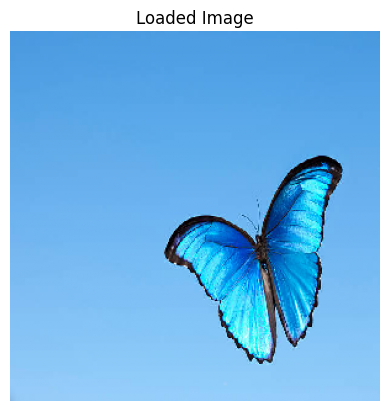

ValueError: in user code:

    File "/Users/chenxin/anaconda3/envs/Tianluo/lib/python3.11/site-packages/keras/engine/training.py", line 2169, in predict_function  *
        return step_function(self, iterator)
    File "/Users/chenxin/anaconda3/envs/Tianluo/lib/python3.11/site-packages/keras/engine/training.py", line 2155, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/chenxin/anaconda3/envs/Tianluo/lib/python3.11/site-packages/keras/engine/training.py", line 2143, in run_step  **
        outputs = model.predict_step(data)
    File "/Users/chenxin/anaconda3/envs/Tianluo/lib/python3.11/site-packages/keras/engine/training.py", line 2111, in predict_step
        return self(x, training=False)
    File "/Users/chenxin/anaconda3/envs/Tianluo/lib/python3.11/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/chenxin/anaconda3/envs/Tianluo/lib/python3.11/site-packages/keras/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 299, 299, 3), found shape=(None, 300, 300, 3)


In [19]:
# Model Testing With Graphs
predict("/Users/chenxin/Desktop/Tianluo/dataset/archive/Butterfly/istockphoto65.jpg")